<h3><b>Question 1</b></h3>

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

# Utility to flatten images

def to_flattened_tensor(dataset):
    X = torch.stack([dataset[i][0] for i in range(len(dataset))])
    return X.view(X.size(0), -1)

# Build encoder and decoder

def build_autoencoder(input_dim, hidden_dims, latent_dim):
    encoder = nn.Sequential(
        nn.Linear(input_dim, hidden_dims[0]), nn.Sigmoid(),
        nn.Linear(hidden_dims[0], hidden_dims[1]), nn.Sigmoid(),
        nn.Linear(hidden_dims[1], latent_dim), nn.Sigmoid()
    )
    decoder = nn.Sequential(
        nn.Linear(latent_dim, hidden_dims[1]), nn.Sigmoid(),
        nn.Linear(hidden_dims[1], hidden_dims[0]), nn.Sigmoid(),
        nn.Linear(hidden_dims[0], input_dim), nn.Sigmoid()
    )
    return encoder, decoder

# Training function

def train_autoencoder(encoder, decoder, loader, criterion, optimizer, device):
    encoder.train(); decoder.train()
    total_loss = 0
    for (batch_X,) in loader:
        batch_X = batch_X.to(device)
        optimizer.zero_grad()
        z = encoder(batch_X)
        X_hat = decoder(z)
        loss = criterion(X_hat, batch_X)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch_X.size(0)
    return total_loss / len(loader.dataset)

# Eval function

def eval_autoencoder(encoder, decoder, loader, criterion, device):
    encoder.eval(); decoder.eval()
    total_loss = 0
    with torch.no_grad():
        for (batch_X,) in loader:
            batch_X = batch_X.to(device)
            X_hat = decoder(encoder(batch_X))
            total_loss += criterion(X_hat, batch_X).item() * batch_X.size(0)
    return total_loss / len(loader.dataset)

# Reconstruction display

def show_reconstructions(encoder, decoder, X, num=8, device='cpu', title=None):
    encoder.eval(); decoder.eval()
    idx = np.random.choice(len(X), num, replace=False)
    samples = X[idx].to(device)
    with torch.no_grad():
        recon = decoder(encoder(samples)).cpu().numpy()
    orig = samples.cpu().numpy()

    fig, axes = plt.subplots(2, num, figsize=(num*1.5,3))
    for i in range(num):
        axes[0,i].imshow(orig[i].reshape(28,28)); axes[0,i].axis('off')
        axes[1,i].imshow(recon[i].reshape(28,28)); axes[1,i].axis('off')
    if title: fig.suptitle(title)
    plt.show()




In [35]:

def run_experiment(latent_dims=[16,48], hidden_dims=[256,128], epochs=20, batch_size=128, lr=1e-3, device='cpu'):
    transform = transforms.ToTensor()
    train_ds = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
    test_ds = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

    X_train = to_flattened_tensor(train_ds)
    X_test = to_flattened_tensor(test_ds)

    train_loader = DataLoader(TensorDataset(X_train), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(X_test), batch_size=batch_size)

    criterion = nn.MSELoss()

    results = {}
    for latent_dim in latent_dims:
        print(f"\n=== Latent Dim: {latent_dim} ===")
        enc, dec = build_autoencoder(28*28, hidden_dims, latent_dim)
        enc.to(device); dec.to(device)
        params = list(enc.parameters()) + list(dec.parameters())
        optimizer = optim.Adam(params, lr=lr)

        for epoch in range(1, epochs+1):
            train_loss = train_autoencoder(enc, dec, train_loader, criterion, optimizer, device)
            test_loss = eval_autoencoder(enc, dec, test_loader, criterion, device)
            if epoch % 10 == 0 or epoch==epochs:
                print(f"Epoch {epoch}, Train MSE: {train_loss:.4f}, Test MSE: {test_loss:.4f}")
        results[latent_dim] = (enc, dec)
    return results, X_train, X_test

results,X_train,X_test = run_experiment(latent_dims=[16,48], hidden_dims=[256,128], epochs=50, batch_size=128, lr=1e-2, device='cpu')



=== Latent Dim: 16 ===
Epoch 10, Train MSE: 0.0183, Test MSE: 0.0180
Epoch 20, Train MSE: 0.0157, Test MSE: 0.0158
Epoch 30, Train MSE: 0.0144, Test MSE: 0.0158
Epoch 40, Train MSE: 0.0134, Test MSE: 0.0140
Epoch 50, Train MSE: 0.0128, Test MSE: 0.0135

=== Latent Dim: 48 ===
Epoch 10, Train MSE: 0.0194, Test MSE: 0.0194
Epoch 20, Train MSE: 0.0155, Test MSE: 0.0155
Epoch 30, Train MSE: 0.0135, Test MSE: 0.0137
Epoch 40, Train MSE: 0.0122, Test MSE: 0.0127
Epoch 50, Train MSE: 0.0115, Test MSE: 0.0121


In [36]:
print(results.keys())

dict_keys([16, 48])


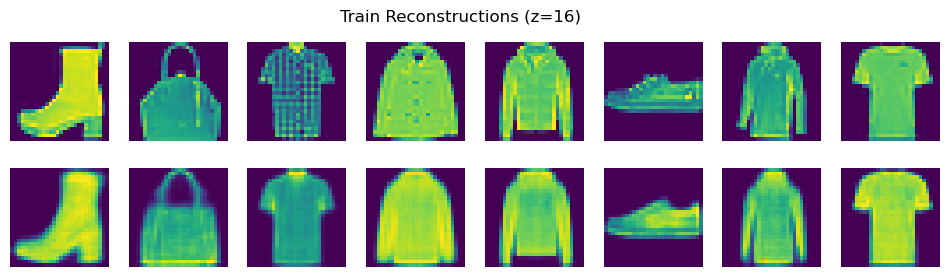

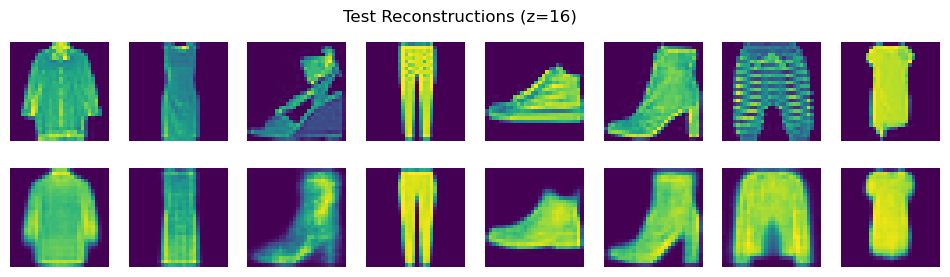

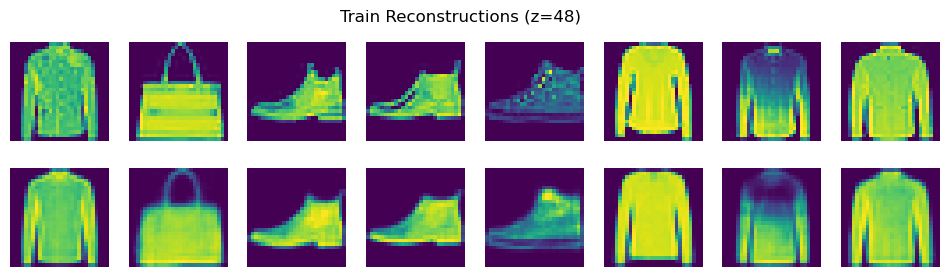

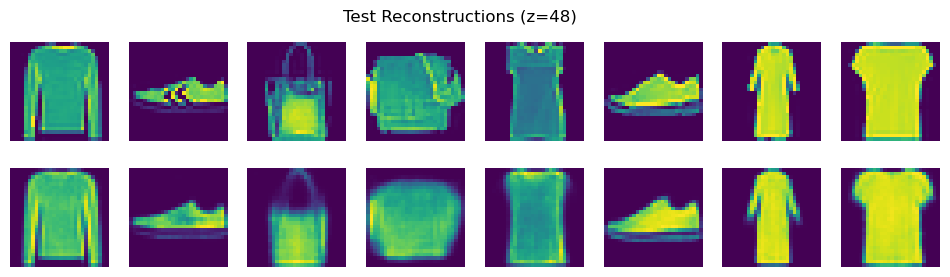

In [37]:
# Plot 8 reconstructions for train and test
latent_dims=[16,48]
for latent_dim in latent_dims:
    enc, dec = results[latent_dim]
    show_reconstructions(enc, dec, X_train, num=8, device='cpu', title=f"Train Reconstructions (z={latent_dim})")
    show_reconstructions(enc, dec, X_test, num=8, device='cpu', title=f"Test Reconstructions (z={latent_dim})")


When comparing reconstructions from autoencoders with latent vector sizes of 16 and 48, it is observed that a larger latent size (48) results in significantly better reconstructions. The outputs are more defined, visually sharper, and more faithful to the original training images. This improvement is due to the model's increased capacity to capture finer structural details and features (such as edges, textures, and shapes) in the higher-dimensional latent space. In contrast, a latent size of 16 leads to blurry and less accurate reconstructions, indicating loss of important visual information. Therefore, increasing the latent dimensionality enhances the model's ability to represent and reconstruct complex inputs effectively.

Latent dim 16


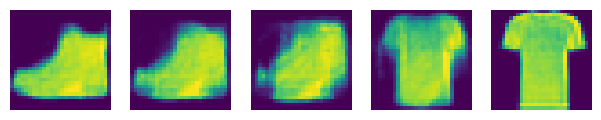

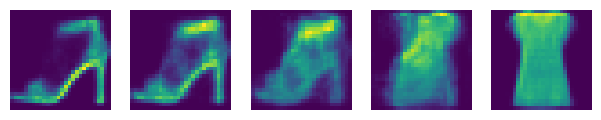

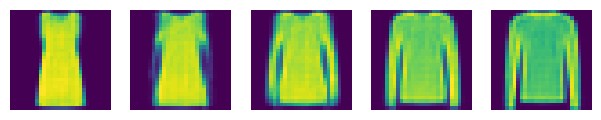

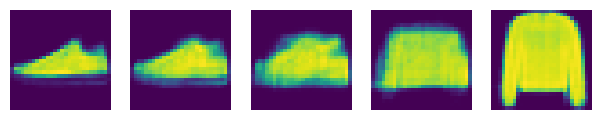

Latent dim 48


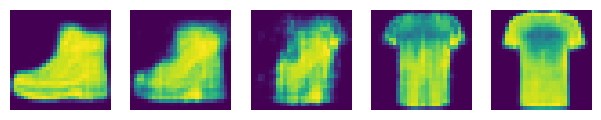

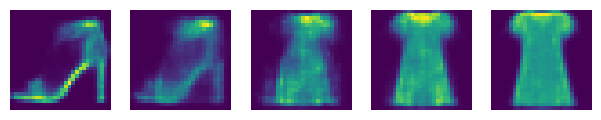

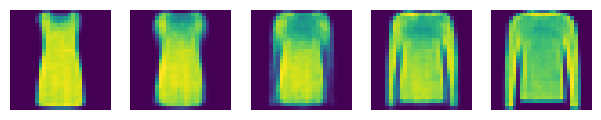

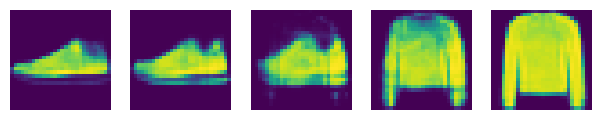

In [38]:
def interpolate_and_show(encoder, decoder, X, pairs, steps=5, device='cpu'):
    encoder.eval(); decoder.eval()
    for (i,j) in pairs:
        x1 = X[i:i+1].to(device); x2 = X[j:j+1].to(device)
        with torch.no_grad():
            z1 = encoder(x1); z2 = encoder(x2)
        linspaces = torch.stack([z1 + t*(z2-z1) for t in np.linspace(0,1,steps)])
        with torch.no_grad():
            recon = decoder(linspaces).cpu().numpy()
        fig, axes = plt.subplots(1, steps, figsize=(steps*1.5,1.5))
        for k in range(steps):
            axes[k].imshow(recon[k].reshape(28,28)); axes[k].axis('off')
        plt.show()

# Interpolate between pairs of samples
enc16, dec16 = results[latent_dims[0]]
print("Latent dim 16")
pairs = [(0,1), (8,3), (4,5), (6,7)]
interpolate_and_show(enc16, dec16, X_train, pairs, steps=5, device='cpu')
print("Latent dim 48")
enc48, dec48 = results[latent_dims[1]]
interpolate_and_show(enc48, dec48, X_train, pairs, steps=5, device='cpu')

- Smooth Transition: The interpolations are continuous, with gradual morphing of structure and features—indicating the model's ability to represent items in a continuous latent space.

- Semantic Shift: The transitions aren't just pixel blends—they show semantic changes (e.g., sleeves forming, shoes becoming tops).

- Intermediate Representations: The middle images often appear ambiguous or unrealistic, which is common during interpolation across different classes.

<h3><b>Question 2</b></h3>

VAE Epoch 10, Train Loss: 26.5682, Test Loss: 26.7273
VAE Epoch 20, Train Loss: 26.3447, Test Loss: 26.2835
VAE Epoch 30, Train Loss: 26.3863, Test Loss: 26.6565

Sampling 50 new images from VAE:


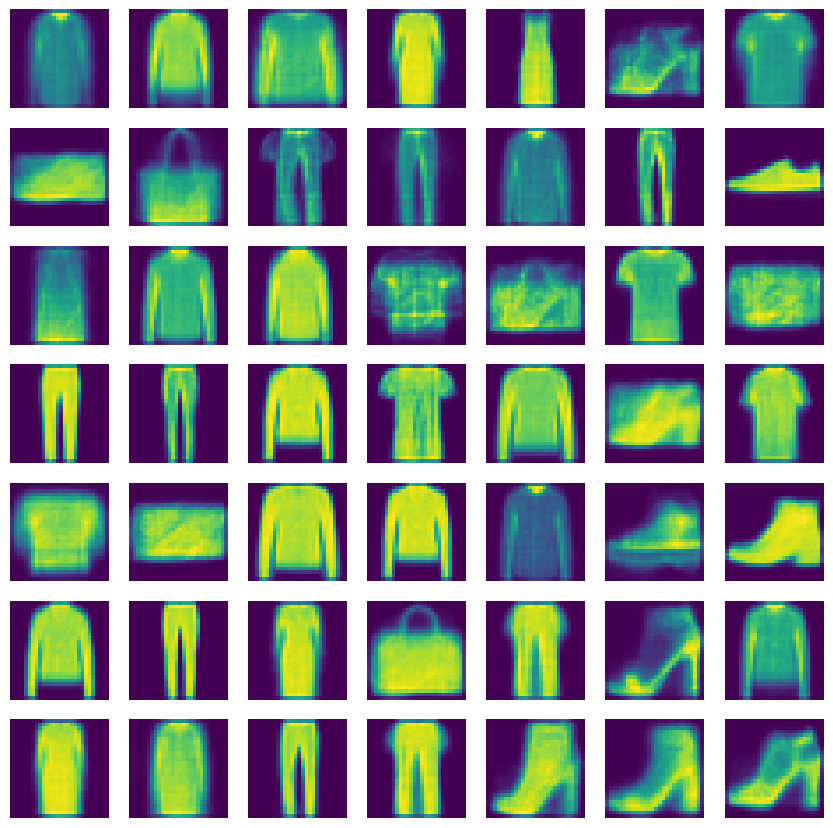

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

def to_flattened_tensor(dataset):
    X = torch.stack([dataset[i][0] for i in range(len(dataset))])
    return X.view(X.size(0), -1)

# Variational Autoencoder (VAE) 

def build_vae(input_dim, hidden_dims, latent_dim):
  
    # encoder network
    enc_net = nn.Sequential(
        nn.Linear(input_dim, hidden_dims[0]), nn.ReLU(),
        nn.Linear(hidden_dims[0], hidden_dims[1]), nn.ReLU()
    )
    # Latent distribution parameters
    mu_layer = nn.Linear(hidden_dims[1], latent_dim)
    logvar_layer = nn.Linear(hidden_dims[1], latent_dim)
    # Decoder network
    dec_net = nn.Sequential(
        nn.Linear(latent_dim, hidden_dims[1]), nn.ReLU(),
        nn.Linear(hidden_dims[1], hidden_dims[0]), nn.ReLU(),
        nn.Linear(hidden_dims[0], input_dim), nn.Sigmoid()
    )
    return enc_net, mu_layer, logvar_layer, dec_net


def reparameterize(mu, logvar):
  
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std


def vae_loss(x_hat, x, mu, logvar):
   
    recon_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return (recon_loss + kld) / x.size(0)


def train_vae(enc_net, mu_layer, logvar_layer, dec_net, loader, optimizer, device):
   
    enc_net.train(); mu_layer.train(); logvar_layer.train(); dec_net.train()
    total_loss = 0
    for (batch_X,) in loader:
        batch_X = batch_X.to(device)
        optimizer.zero_grad()
        h = enc_net(batch_X)
        mu, logvar = mu_layer(h), logvar_layer(h)
        z = reparameterize(mu, logvar)
        x_hat = dec_net(z)
        loss = vae_loss(x_hat, batch_X, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch_X.size(0)
    return total_loss / len(loader.dataset)


def eval_vae(enc_net, mu_layer, logvar_layer, dec_net, loader, device):
   
    enc_net.eval(); mu_layer.eval(); logvar_layer.eval(); dec_net.eval()
    total_loss = 0
    with torch.no_grad():
        for (batch_X,) in loader:
            batch_X = batch_X.to(device)
            h = enc_net(batch_X)
            mu, logvar = mu_layer(h), logvar_layer(h)
            z = reparameterize(mu, logvar)
            x_hat = dec_net(z)
            total_loss += vae_loss(x_hat, batch_X, mu, logvar).item() * batch_X.size(0)
    return total_loss / len(loader.dataset)


def sample_vae(dec_net, latent_dim, num_samples=50, device='cpu'):

    dec_net.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)
        samples = dec_net(z).cpu().numpy()
    rows = int(np.sqrt(num_samples))
    fig, axes = plt.subplots(rows, rows, figsize=(rows*1.5, rows*1.5))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(samples[i].reshape(28,28))
        ax.axis('off')
    plt.show()


def run_vae_experiment(latent_dim=12, hidden_dims=[256,128], epochs=30,
                       batch_size=128, lr=1e-3, device='cpu'):
   
    transform = transforms.ToTensor()
    train_ds = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
    test_ds = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
    X_train = to_flattened_tensor(train_ds)
    X_test = to_flattened_tensor(test_ds)
    train_loader = DataLoader(TensorDataset(X_train), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(X_test), batch_size=batch_size)

    enc_net, mu_layer, logvar_layer, dec_net = build_vae(28*28, hidden_dims, latent_dim)
    for module in (enc_net, mu_layer, logvar_layer, dec_net):
        module.to(device)

    optimizer = optim.Adam(
        list(enc_net.parameters()) + list(mu_layer.parameters()) + 
        list(logvar_layer.parameters()) + list(dec_net.parameters()),
        lr=lr
    )

    for epoch in range(1, epochs+1):
        tr_loss = train_vae(enc_net, mu_layer, logvar_layer, dec_net, train_loader, optimizer, device)
        te_loss = eval_vae(enc_net, mu_layer, logvar_layer, dec_net, test_loader, device)
        if epoch % 10 == 0 or epoch == epochs:
            print(f"VAE Epoch {epoch}, Train Loss: {tr_loss:.4f}, Test Loss: {te_loss:.4f}")
    return enc_net, mu_layer, logvar_layer, dec_net, X_train


enc_net, mu_layer, logvar_layer, dec_net, X_train = run_vae_experiment(latent_dim=12, hidden_dims=[256,128], epochs=30, batch_size=128, lr=1e-2, device='cpu')
print("\nSampling 50 new images from VAE:")
sample_vae(dec_net, latent_dim=12, num_samples=50, device='cpu')


Diversity
- The samples show a wide range of Fashion-MNIST categories: shirts, pants, dresses, shoes, bags, and coats are all visible.

- There’s a variety in shapes, indicating the model has captured distinct structural features of each class.

- Pose and orientation also vary slightly across samples, which adds to the diversity.

Quality & Recognizability

-Many items are reasonably clear and identifiable.

-Sweaters and coats (1st and 5th rows) have good symmetry and sleeve visibility.

-Trousers (e.g., 2nd and 6th columns of several rows) are long and straight, easily distinguishable.

-Shoes and boots (bottom right) show decent contours and heel/sole shapes.

A few samples (e.g., some T-shirts or tops in the middle rows) appear a bit blurry or noisy, possibly due to imperfect generation or reconstruction—still, most are recognizable as belonging to Fashion-MNIST.

<h3> <b>Bonus</b> </h3>


Tweaking latent dimension 0 by [2 , -1 , -2, -4]:


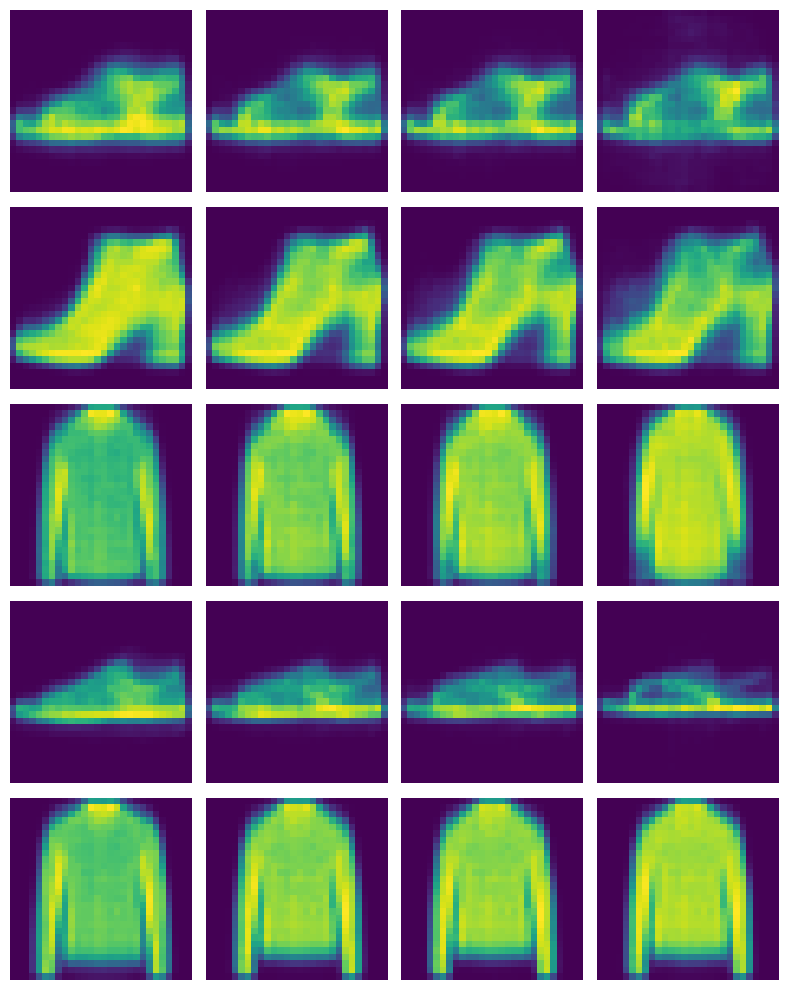

In [34]:
def tweak_latent(enc_net, mu_layer, logvar_layer, dec_net, X, dim, shifts, num_images=5, device='cpu'):
    enc_net.eval(); dec_net.eval()
    
    fig, axes = plt.subplots(num_images, len(shifts), figsize=(len(shifts)*2, num_images*2))
    
    if num_images == 1:
        axes = [axes]
    elif len(shifts) == 1:
        axes = [[ax] for ax in axes]

    idxs = np.random.choice(len(X), num_images, replace=False)

    for row, idx in enumerate(idxs):
        x = X[idx].unsqueeze(0).to(device)
        with torch.no_grad():
            mu = mu_layer(enc_net(x))
            logvar = logvar_layer(enc_net(x))
            std = torch.exp(0.5 * logvar)
            z = mu + torch.randn_like(std) * std

        for col, s in enumerate(shifts):
            z_t = z.clone()
            z_t[0, dim] += s * std[0, dim]
            with torch.no_grad():
                img = dec_net(z_t).cpu().numpy()[0]
            axes[row][col].imshow(img.reshape(28, 28))
            axes[row][col].axis('off')

    plt.tight_layout()
    plt.show()

print("\nTweaking latent dimension 0 by [2 , -1 , -2, -4]:")
tweak_latent(enc_net, mu_layer, logvar_layer, dec_net, X_train, dim=0, shifts=[2,-1,-2,-4], device='cpu')